#  **Home Price Prediction: ML Modeling**

###  **Goals**

- Build a machine learning model to `predict price per square foot` for `residential properties`


- `Separate land listings from built properties` to improve modeling accuracy and allow for search classification


- Use `feature engineering` and `city-level encoding` to enhance `predictive performance`


- Develop a `prediction function` that suggests housing options based on user-defined preferences


- `Rank listings by predicted price per square foot` to highlight the `most desirable and cost-effective properties for the user`


### **Importing Libraries**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor # I tested multiple different modeling approaches and random forest seem to predict best on all three models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import joblib

### **Loading Cleaned Data**

In [3]:
df = pd.read_csv("housing_modeling_data.csv")

### **Split Land vs Property Listings**

- This step ensures better modeling outcomes by handling land and property listings separately

- Land listings often contain values that would be considered outliers in residential property data (very high acreage, missing square footage), but are typical for vacant land

- Separating them prevents skewing the property model and allows `each model to learn from more relevant feature distributions`

In [4]:
df_land = df[df["property_type"] == "Land"].copy()
df_home = df[df["property_type"] != "Land"].copy()

### **Clean Land Data**

- I drop columns not relevant to land (beds, baths) 

- Handled missing values, and filter out listings without a valid city (useful for later encoding)


In [5]:
df_land.drop(columns=["beds", "baths", "square_feet","year_built","price_per_sqft"], inplace=True)
df_land["acres"] = df_land["acres"].fillna(df_land["acres"].median())
df_land.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5090 entries, 0 to 21629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         5090 non-null   object 
 1   city            5086 non-null   object 
 2   price           5090 non-null   int64  
 3   status          5090 non-null   object 
 4   acres           5090 non-null   float64
 5   days_on_market  5090 non-null   int64  
 6   property_type   5090 non-null   object 
 7   hoa_per_month   5090 non-null   int64  
 8   url             5090 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 397.7+ KB


In [6]:
# remove all land values where city is na because the land encoded needs all non nan values
df_land = df_land[df_land["city"].notna()]


### **Encode Land Listings**

- City names are encoded using `average land` prices per city

- This allows the model to learn `geographic patterns`

In [ ]:
# land encoded to convert cities to a numerical format in order to add city as a feature to try and increase model accuracy - (this is done for land and property values)
land_avg_ppsqft = df_land.groupby("city")["price"].mean()
df_land["land_encoded"] = df_land["city"].map(land_avg_ppsqft)

### **Clean Home Data**

- Fill missing values in `beds`, `baths`, and `acres`

- For missing `year_built`, I used recent years to keep the sample

- The distribution for year_built was primarily focued from 2000-present so I randomly chose a value within (2000-2024) as nan replacements 

- This prevents dropping too many rows unnecessarily


In [ ]:
df_home["beds"] = df_home["beds"].fillna(0)

df_home["baths"] = df_home["baths"].fillna(0)

df_home["acres"] = df_home["acres"].fillna(df_home["acres"].median())

df_home["year_built"] = df_home["year_built"].apply(
    lambda x: x if not np.isnan(x) else np.random.randint(2000, 2024)
)

df_home.info()

df_home["property_type"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 16541 entries, 4 to 21630
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         16541 non-null  object 
 1   city            16541 non-null  object 
 2   beds            16541 non-null  float64
 3   baths           16541 non-null  float64
 4   price           16541 non-null  int64  
 5   status          16541 non-null  object 
 6   square_feet     16541 non-null  float64
 7   acres           16541 non-null  float64
 8   year_built      16541 non-null  float64
 9   days_on_market  16541 non-null  int64  
 10  property_type   16541 non-null  object 
 11  hoa_per_month   16541 non-null  int64  
 12  url             16541 non-null  object 
 13  price_per_sqft  16541 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 1.9+ MB


property_type
Single Family         11841
Townhouse              2491
Condo                  2114
Multi-Family             83
Large Multi-Family        8
Ranch                     4
Name: count, dtype: int64

### **Remove Outliers From Price On Land Values**
- This will help the model predict Land price values more `accurately`

In [9]:
# df land - even with land encoder and log prices is still not performing great and can be improved. - removing upper limit values to make land prices more realistic to normal land/home buyers - cutting off land price at 95% quantile 
upper_limit = df_land["price"].quantile(0.95) # cut off around 1 million dollars 
df_land = df_land[df_land["price"] < upper_limit]


### **Encode Categorical Variables In Property DataFrame**

- `One hot endcoded property type` so the model is able to use the values for predicting

- Also, created a `city_encoded` variable that is similar to lands encoded value. Based on `avg sqft by cities` we are easily able to `assign weights` to each `individual city allowing it to be used in predictions`

- The city encoded value in predicting `cut the mae and rmse both by 50% greatly increasing accuracy of predictions.`

In [10]:
df_home = pd.get_dummies(df_home, columns=["property_type"], drop_first=False)
df_home.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16541 entries, 4 to 21630
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   address                           16541 non-null  object 
 1   city                              16541 non-null  object 
 2   beds                              16541 non-null  float64
 3   baths                             16541 non-null  float64
 4   price                             16541 non-null  int64  
 5   status                            16541 non-null  object 
 6   square_feet                       16541 non-null  float64
 7   acres                             16541 non-null  float64
 8   year_built                        16541 non-null  float64
 9   days_on_market                    16541 non-null  int64  
 10  hoa_per_month                     16541 non-null  int64  
 11  url                               16541 non-null  object 
 12  price_per

In [ ]:
# calculate average price_per_sqft by city then encode cities - helps model by around 50%
city_avg_ppsqft = df_home.groupby("city")["price_per_sqft"].mean()
df_home["city_encoded"] = df_home["city"].map(city_avg_ppsqft)


### **Train The Model**

- I aimed to predict price_per_sqft, which helps normalize for home size

- `Log-transforming` the target value `improves performance on heavily skewed data`

- This lets the model compare numeric values a lot easier

- I used the `Random Forest Regressor` due to its ability to `capture nonlinear relationships`. 

- The model is `trained on 80% of the data and tested on the remaining 20%.`


In [ ]:
## property model: trying to predict price per square foot
features_property = [
    "city_encoded", "beds", "baths", "square_feet", "acres", "year_built",
    "days_on_market", "hoa_per_month",
    "property_type_Townhouse", "property_type_Condo", "property_type_Single Family",
    "property_type_Multi-Family", "property_type_Ranch"
]

X_prop = df_home[features_property]
y_prop = np.log1p(df_home["price_per_sqft"])  # log1p handles 0 safely


# train test split
X_prop_train, X_prop_test, y_prop_train, y_prop_test = train_test_split(X_prop, y_prop, test_size=0.2, random_state=42)

# train
model_prop = RandomForestRegressor(random_state=42)
model_prop.fit(X_prop_train, y_prop_train)

# predict
y_prop_pred_log = model_prop.predict(X_prop_test)

# reverse log values to get actual price per sqft
y_prop_pred = np.expm1(y_prop_pred_log)
y_prop_test_actual = np.expm1(y_prop_test)

# evaluation
mae_prop = mean_absolute_error(y_prop_test_actual, y_prop_pred)
rmse_prop = mean_squared_error(y_prop_test_actual, y_prop_pred, squared=False)


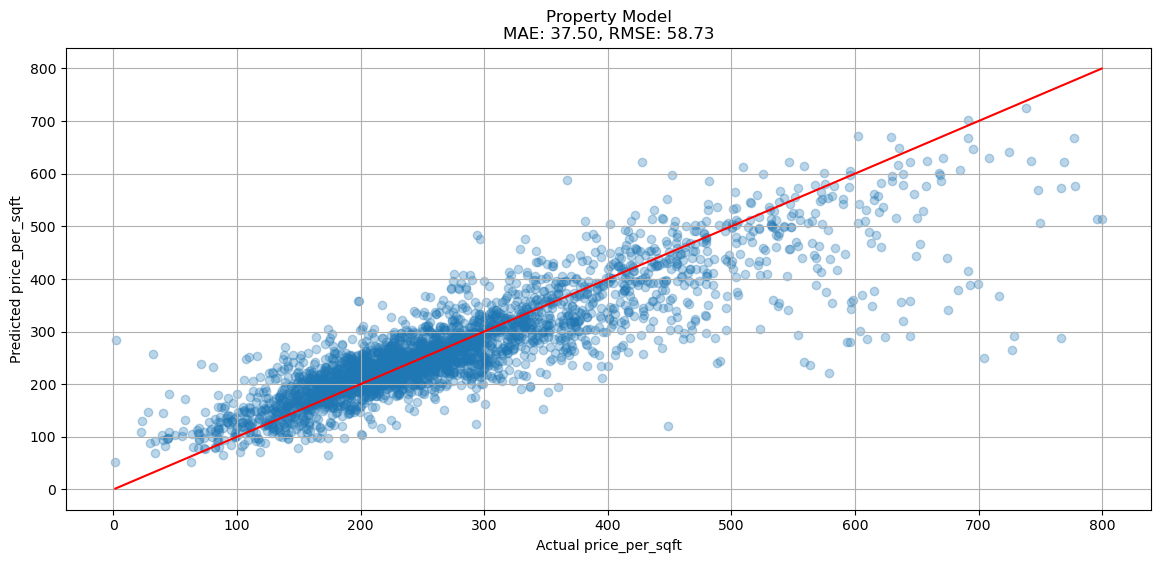

In [38]:
plt.figure(figsize=(14, 6))
plt.scatter(y_prop_test_actual, y_prop_pred, alpha=0.3)  # original scale
plt.plot([y_prop_test_actual.min(), y_prop_test_actual.max()],
         [y_prop_test_actual.min(), y_prop_test_actual.max()],
         'r')
plt.title(f"Property Model\nMAE: {mae_prop:.2f}, RMSE: {rmse_prop:.2f}")
plt.xlabel("Actual price_per_sqft")
plt.ylabel("Predicted price_per_sqft")
plt.grid(True)
plt.show()


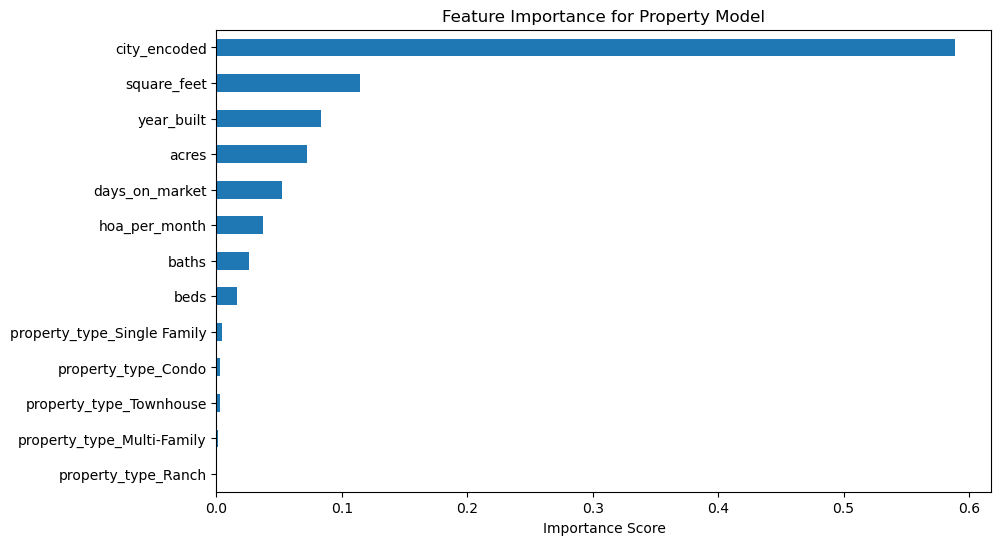

In [ ]:
# graphing feature importance to better understand what values had the most prediciton power and swayed the model more
importances = model_prop.feature_importances_
feat_importance = pd.Series(importances, index=features_property)


feat_importance = feat_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh')
plt.title("Feature Importance for Property Model")
plt.xlabel("Importance Score")
plt.show()

### **Evaluating The Models Performance**


- After several adjustments to the data and model, I achieved a prediction error of `approximately ± $37.50 per square foot.`


- `Log-transforming` the target variable and `encoding cities` based on average price per square foot significantly improved accuracy. Approximately an `~70% reduction in error.`


- These improvements are largely due to giving the model more `normalized information to learn` from — making `patterns easier to detect` and `reducing the impact of extreme values.`


- city_encoded and square feet hold the most predictive power in the feature importance graph, which makes sense


- I am surprised beds and baths dont have more power, but they seemed to correlate more with price compared to price/sqft

In [ ]:
# land model
features_land = ["land_encoded", "acres", "days_on_market", "hoa_per_month"]
X_land = df_land[features_land]
y_land = np.log1p(df_land["price"])  # log1p to handle skew and 0s safely

# train/test
X_land_train, X_land_test, y_land_train, y_land_test = train_test_split(
    X_land, y_land, test_size=0.2, random_state=42
)

# training
model_land = RandomForestRegressor(random_state=42)
model_land.fit(X_land_train, y_land_train)

# prediction
y_land_pred_log = model_land.predict(X_land_test)

# convert back to original price
y_land_pred = np.expm1(y_land_pred_log)
y_land_test_actual = np.expm1(y_land_test)

# evaluation
mae_land = mean_absolute_error(y_land_test_actual, y_land_pred)
rmse_land = mean_squared_error(y_land_test_actual, y_land_pred, squared=False)


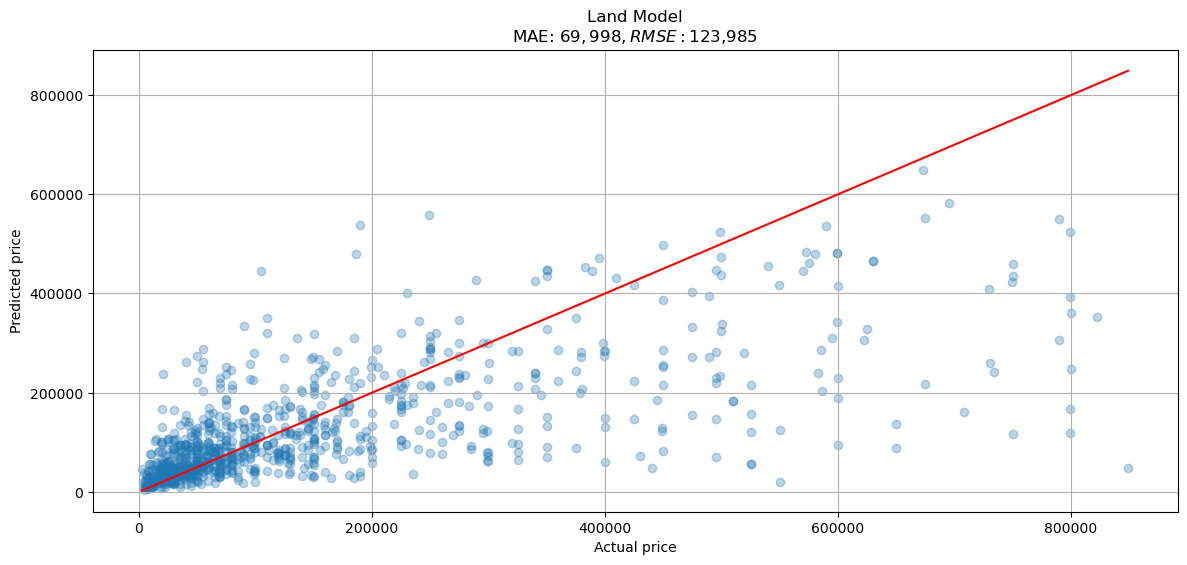

In [45]:
plt.figure(figsize=(14, 6))
plt.scatter(y_land_test_actual, y_land_pred, alpha=0.3)
plt.plot([y_land_test_actual.min(), y_land_test_actual.max()],
         [y_land_test_actual.min(), y_land_test_actual.max()],
         'r')
plt.title(f"Land Model\nMAE: ${mae_land:,.0f}, RMSE: ${rmse_land:,.0f}")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.grid(True)
plt.show()


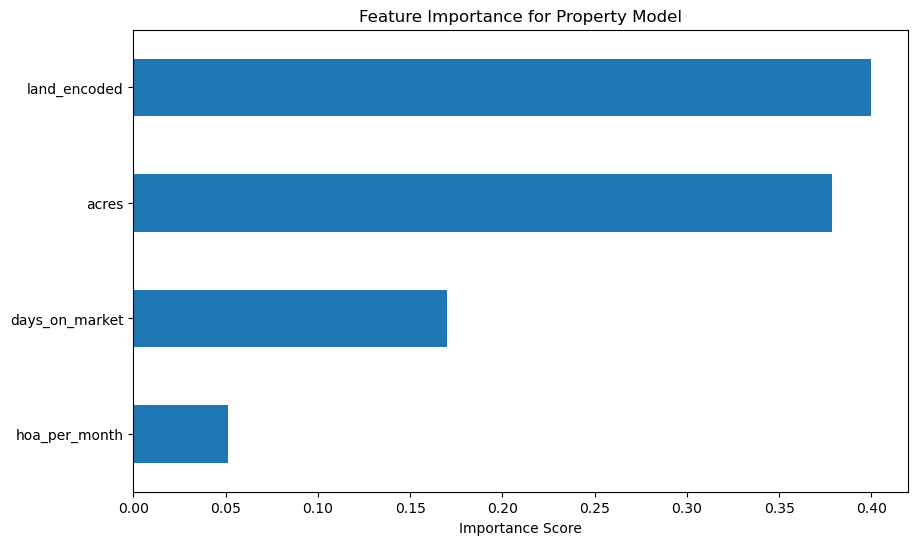

In [ ]:
# graph of importance for land features. 
importances = model_land.feature_importances_
feat_importance = pd.Series(importances, index=features_land)


feat_importance = feat_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh')
plt.title("Feature Importance for Property Model")
plt.xlabel("Importance Score")
plt.show()

 ### **Prediction Function Overview**

- The final prediction functions takes in a user's preferences (like number of beds, baths, square footage, acreage, and desired property type) and returns a ranked list of top listings based on predicted price per square foot.

- By predicting price `efficiency (with price/sqft) rather than total price`, the function helps identify properties that offer the `best value for the user's criteria.`

- The model uses a trained Random Forest to estimate the price per square foot, then multiplies it by the actual square footage of each listing to estimate total price.

- Listings are then filtered and sorted to highlight the most `affordable and desirable options`, matching the user's preferences while `emphasizing value.`

- This approach enables smarter home discovery by prioritizing properties that deliver more for their cost.

- As expected land_encoded and acres perform the best and hold the most sway in the model

In [ ]:
def recommend_top_properties(df, model, features,
                             min_beds=3, max_beds=5,
                             min_baths=2, max_baths=4,
                             min_price=0, max_price=600000,
                             allowed_types=None,
                             min_acres=0.0, max_acres=10.0,
                             min_year_built=1950,
                             min_square_feet=1000, max_square_feet=5000,
                             hoa_allowed=True,
                             city=None,
                             top_n=5):

    if allowed_types is None:
        allowed_types = ["property_type_Single Family", "property_type_Townhouse"]

    # city filter - accepts string or list of cities
    if city:
        if isinstance(city, str):
            city_filter = (df["city"] == city)
        else:
            city_filter = df["city"].isin(city)
    else:
        city_filter = True  # no city filter if not provided

    # HOA filter
    hoa_filter = (df["hoa_per_month"] >= 0) if hoa_allowed else (df["hoa_per_month"] == 0)

    # remaining feature filters
    filters = (
        (df["beds"] >= min_beds) &
        (df["beds"] <= max_beds) &
        (df["baths"] >= min_baths) &
        (df["baths"] <= max_baths) &
        (df["price"] >= min_price) &
        (df["price"] <= max_price) &
        (df["acres"] >= min_acres) & (df["acres"] <= max_acres) &
        (df["year_built"] >= min_year_built) &
        (df["square_feet"] >= min_square_feet) & (df["square_feet"] <= max_square_feet) &
        (df[allowed_types].any(axis=1)) &
        hoa_filter &
        city_filter
    )

    filtered_df = df[filters].copy()

    if filtered_df.empty:
        return "No matching homes found. (widen search)"

    # predict log price then convert back to actual values
    X_input = filtered_df[features]
    filtered_df["predicted_ppsqft"] = np.expm1(model.predict(X_input))
    filtered_df["predicted_price"] = filtered_df["predicted_ppsqft"] * filtered_df["square_feet"]

    return filtered_df.sort_values(by="predicted_price").head(top_n)[
    ["address", "city", "beds", "baths", "square_feet", "price"]
]



In [17]:
top_homes = recommend_top_properties(
    df_home,
    model_prop,
    features_property,
    min_beds=3,
    max_beds=5,
    min_baths=3,
    max_baths=5,
    min_price=50000,
    max_price=600000,
    city= [], # you can input any city in Virginia (["Abingdon","Williamsburg"] etc)
    allowed_types=["property_type_Townhouse", "property_type_Condo", "property_type_Single Family",
    "property_type_Multi-Family", "property_type_Ranch"], # this includes all house types, remove undesired ones
    min_acres=2.0,
    max_acres=100.0,
    min_year_built=0,
    min_square_feet=0,
    max_square_feet=5000,
    hoa_allowed=False,
    top_n=5
)

top_homes[["address", "city", "beds", "baths", "square_feet", "price"]]


,address,city,beds,baths,square_feet,price
17020,10 Maplewood Dr,South Boston,4.0,3.0,1771.0,170000
19355,1658 Jakes Fork Rd,Vansant,5.0,3.0,2850.0,179000
8101,5290 Crumptown Rd,Farmville,3.0,3.0,2497.0,199999
9949,2149 Cowford Rd,Halifax,3.0,3.0,2000.0,449900
18553,124 Sunset Dr,Stuart,4.0,3.0,2777.0,238900


In [ ]:
# same steps as previous model
def recommend_top_land(df, model, features,
                       min_acres=0.0, max_acres=10.0,
                       min_price=0, max_price=600000,
                       city=None,
                       top_n=5):

    
    if city:
        if isinstance(city, str):
            city_filter = (df["city"] == city)
        else:
            city_filter = df["city"].isin(city)
    else:
        city_filter = True

   
    filters = (
        (df["price"] >= min_price) &
        (df["price"] <= max_price) &
        (df["acres"] >= min_acres) &
        (df["acres"] <= max_acres) &
        (df["acres"] > 0) &
        city_filter
    )

    filtered_df = df[filters].copy()

    if filtered_df.empty:
        return "No land areas found.(widen search)"

    
    X_input = filtered_df[features]
    filtered_df["predicted_price"] = np.expm1(model.predict(X_input))

    
    return filtered_df.sort_values(by="predicted_price").head(top_n)[
        ["address", "city", "acres", "price"]
    ]


In [ ]:
top_land = recommend_top_land(
    df_land,
    model_land,
    features_land,
    min_acres=5.0,
    max_acres=100.0,
    min_price=25000,
    max_price=150000,
    city=[], # input any cities inside of Virginia
    top_n=5 
)

display(top_land)


,address,city,acres,price
13837,20 High Valley South,Monterey,5.00,25000
13813,High Valley South,Monterey,5.02,28000
3219,0 Hunter Rd,Brookneal,5.11,29900
17922,TBD Georges Run Rd,Shawsville,5.72,28000
4948,00 Bearskin Rd,Chatham,5.01,29900


In [ ]:
# price prediciton model: a lot of the same ideas as previous 2 models
X_prop = df_home[features_property]
y_prop = np.log1p(df_home["price"])  

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X_prop, y_prop, test_size=0.2, random_state=42)

# train
model_price = RandomForestRegressor(random_state=42)
model_price.fit(X_train, y_train)

# prediction and evaluation
y_pred_log = model_price.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

mae = mean_absolute_error(y_test_actual, y_pred)
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)

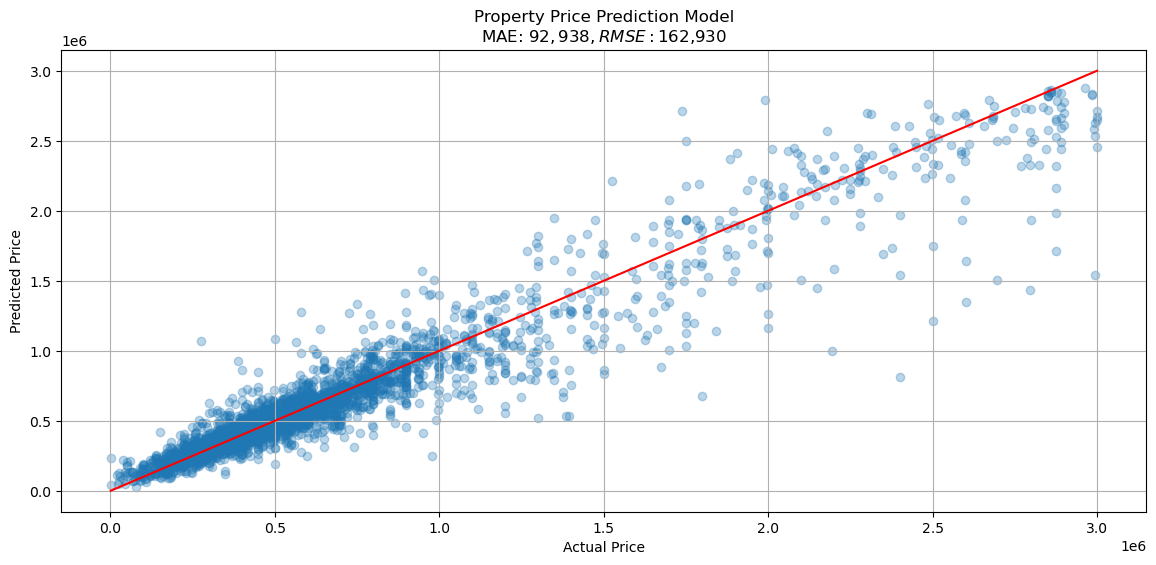

In [21]:
plt.figure(figsize=(14, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.3)
plt.plot(
    [y_test_actual.min(), y_test_actual.max()],
    [y_test_actual.min(), y_test_actual.max()],
    'r'
)
plt.title(f"Property Price Prediction Model\nMAE: ${mae:,.0f}, RMSE: ${rmse:,.0f}")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()


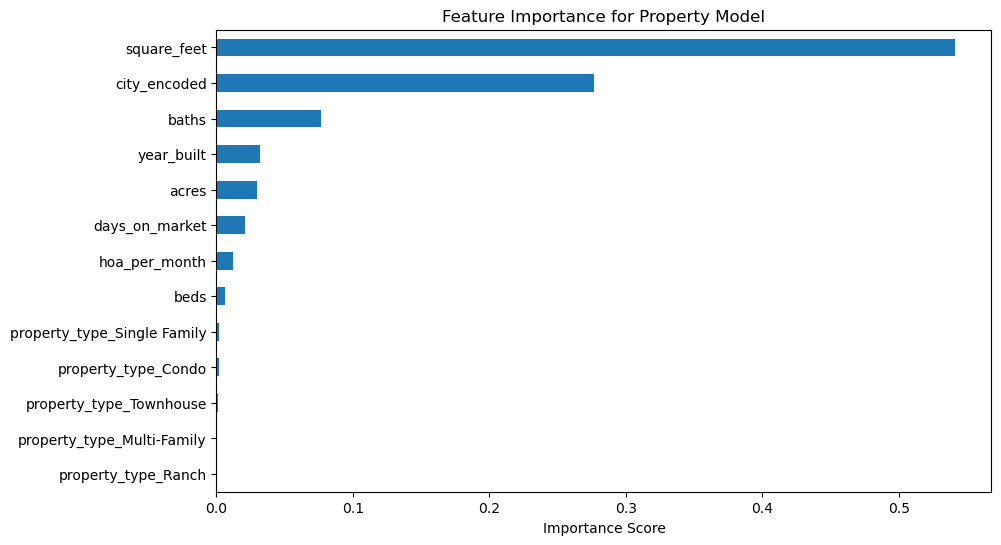

In [ ]:
# feature importance for pricing prediction
importances = model_price.feature_importances_
feat_importance = pd.Series(importances, index=features_property)


feat_importance = feat_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_importance.plot(kind='barh')
plt.title("Feature Importance for Property Model")
plt.xlabel("Importance Score")
plt.show()

### **Pricing Model Performance**

- These results suggest the model performs within `3–5% error on average, which is reasonable for real estate data,` especially dealing with `scraping limitations`

- Based on the results in the prediction program I created, `square footage, city and lot size tend to be the most powerful prediction contributors` to the model

- I also observed that `bedroom and bathroom counts contributed less,` likely due to their correlation with square footage and low variance across listings

- Feature importance shows that the `pricing vs price/sqft models hold features at slightly different importance levels.`

- `baths seem to make a large leap` to the top comparitivly this is expected based on eda because `price was closely correlated with baths`

In [ ]:
# create a mapping from city name to its encoded value
city_to_encoded = df_home.drop_duplicates(subset=["city", "city_encoded"]).set_index("city")["city_encoded"].to_dict()

In [ ]:
def predict_home_price(input_features: dict, model, feature_columns, city_mapping):
 
    # convert city name to encoded value
    city_name = input_features.pop("city", None)
    if city_name is None or city_name not in city_mapping:
        raise ValueError(f"City '{city_name}' not found in mapping.")
    
    input_features["city_encoded"] = city_mapping[city_name]
    
    # create DataFrame in correct column order
    input_df = pd.DataFrame([input_features], columns=feature_columns)
    
    # predict with log value then reverse log1p
    log_price = model.predict(input_df)
    return round(np.expm1(log_price[0]), 2)


In [ ]:
# input values for pricing predictions
example_input = {
    "city": "Lexington",           
    "beds": 10,
    "baths": 10,
    "square_feet": 2000,
    "acres": 15,
    "year_built": 2025,
    "days_on_market": 0,
    "hoa_per_month": 0,
    "property_type_Townhouse": 0,
    "property_type_Condo": 1,
    "property_type_Single Family": 0,
    "property_type_Multi-Family": 0,
    "property_type_Ranch": 0
}

predicted_price = predict_home_price(example_input, model_price, features_property, city_to_encoded)
print(f"Predicted Price: ${predicted_price:,.2f}")


Predicted Price: $527,936.64


In [ ]:
# dumping model and city mapping for streamlit program 
joblib.dump(model_price, "model_price.pkl")
joblib.dump(city_to_encoded, "city_mapping.pkl")

['city_mapping.pkl']

# **Key Takeaways**

- City-level encoding `greatly improved accuracy` on all modeling approaches (reduced MAE and RMSE by close to ~50%) 


- Log-transforming price `stabilized training and reduced the impact of outliers`, again for all models (reduced both MAE and RMSE by another ~20%)


- `Square footage, acres, and location` were the most influential features for all property models 


- beds and baths both `didn't have much prediction power for any models.` This is likely due to there not being a huge range of values after the outliers we removed


- price_per_sqft modeling helped `identify high-value listings` regardless of total price of the listing


- I built a separate model that `predicts total home price for different user use cases` (building a home and wanting to understand the value of the property post-build or trying to get a good idea of what value youre home will sell for before listing on market) 


- A Streamlit interface was built for `live, user price predictions` based on home features.



This notebook serves as a implementation of the ML modeling process inside the entire housing analysis project